# 数据获取

通过sklearn提供的方法来获取数据，并拆分出训练集和测试集。

通过`split_mode`和`keep_meta`两个参数，控制切分策略和元数据保留策略。

In [1]:
import os,sys
import pickle
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from pprint import pprint
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
split_mode = 'TIME'
keep_meta = True

if keep_meta:
    removel = ('footers')
else:
    removel = ('footers', 'quotes')
    
if split_mode == 'TIME':
    newsgroups_train = fetch_20newsgroups(data_home='.', subset='train', remove=removel)
    newsgroups_test = fetch_20newsgroups(data_home='.', subset='test', remove=removel)
elif split_mode == 'RANDOM':
    newsgroups_train = fetch_20newsgroups(data_home='.', subset='all', remove=removel)
else:
    raise Exception('Unknown split_mode: {}'.format(split_mode))
    
newsgroups_target_names = newsgroups_train.target_names

In [3]:
# 查看类别名称
print(newsgroups_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [4]:
def preprocess_data(doc):
    '''
    保留header中的Subject（标题）信息
    doc: 输入文档字符串
    return: header仅保留Subject的文档字符串, quote中去掉In article引用来源行
    '''
    sections = doc.split('\n\n')
    headers = sections[0].split('\n')
    filtered_sections = []
    for section in sections[1:]:
        lines = section.split('\n')
        filtered_sections.append('\n'.join([l for l in lines if not l.startswith('In article')]))
    for header in headers:
        if header.startswith('Subject:'):
            return '\n\n'.join([header] + filtered_sections)

In [5]:
# 检查数据内容
print('category: {}'.format(newsgroups_target_names[newsgroups_train.target[0]]))
print('==============')
print(newsgroups_train.data[1100])

category: rec.autos
From: julie@eddie.jpl.nasa.gov (Julie Kangas)
Subject: Re: Blast them next time
Nntp-Posting-Host: eddie.jpl.nasa.gov
Organization: Jet Propulsion Laboratory, Pasadena, CA
Distribution: usa
Lines: 32

In article <1r19l9$7dv@usenet.INS.CWRU.Edu> oldham@ces.cwru.edu (Daniel Oldham) writes:
>What happened in Waco is not the fault of the BATF. If they would of
>had the proper equipment and personal then they could of captured the
>compound on the initial assault and none of this would of happened.
>
>The BATF needs more people, better weapons and more armored
>transports. When they meet hostile fire they should be able to use
>more force instead of retreating to a stand off. If you are going to
>do a job then do it right. The BATF is there to protect us and they
>must have the proper equipment and people to do the job.
>
>With the WoD and the increased crime in the streets the BATF is needed
>more now then ever. If they blast away a few good fokes then that is
>the pric

## 数据分割

In [6]:
if split_mode == 'TIME':
    # 先划分训练集和测试集
    X_train, y_train = [preprocess_data(i) for i in newsgroups_train.data], newsgroups_train.target
    X_test, y_test = [preprocess_data(i) for i in newsgroups_test.data], newsgroups_test.target

    # 训练集进一步划分为训练集和验证集
    X_train_dev, X_val, y_train_dev, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)
elif split_mode == 'RANDOM':
    X_train, y_train = [preprocess_data(i) for i in newsgroups_train.data], newsgroups_train.target
    
    # 先划分训练集和测试集，随机划分时，训练集保留40%，使得训练集大小与按时间分隔时近似，方便比较
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, random_state=0, stratify=y_train)
    # 训练集进一步划分为训练集和验证集
    X_train_dev, X_val, y_train_dev, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)
else:
    raise Exception('Unknown split_mode: {}'.format(split_mode))

In [7]:
print('train size: {}'.format(len(X_train)))
print('train dev size: {}'.format(len(X_train_dev)))
print('val size: {}'.format(len(X_val)))
print('test size: {}'.format(len(X_test)))

train size: 11314
train dev size: 9051
val size: 2263
test size: 7532


In [8]:
# 查看经过处理过的数据
print(X_train[1100])

Subject: Re: Blast them next time

>What happened in Waco is not the fault of the BATF. If they would of
>had the proper equipment and personal then they could of captured the
>compound on the initial assault and none of this would of happened.
>
>The BATF needs more people, better weapons and more armored
>transports. When they meet hostile fire they should be able to use
>more force instead of retreating to a stand off. If you are going to
>do a job then do it right. The BATF is there to protect us and they
>must have the proper equipment and people to do the job.
>
>With the WoD and the increased crime in the streets the BATF is needed
>more now then ever. If they blast away a few good fokes then that is
>the price we all have to pay for law and order in this country. Look
>at all the good people that died in wars to protect this great country
>of ours.
>
>With the arms build up in Waco they needed to hit that compound with
>mega fire power. They could of gone in there blasting and 

# 数据探索

首先检查训练集、验证集和测试集类别分布情况，看数据在类别上的分布是否有倾斜。

In [9]:
def label_distributation(data, title):
    '''
    展示数据类别分布直方图
    data: pandas DataFrame，包含catid，数值型的分类标签
    '''
    label_dist = data['catid'].value_counts().sort_index().rename(dict([(i, cid) for i, cid in enumerate(newsgroups_target_names)]))
    label_dist.plot.bar(title=title, figsize=(10,5))

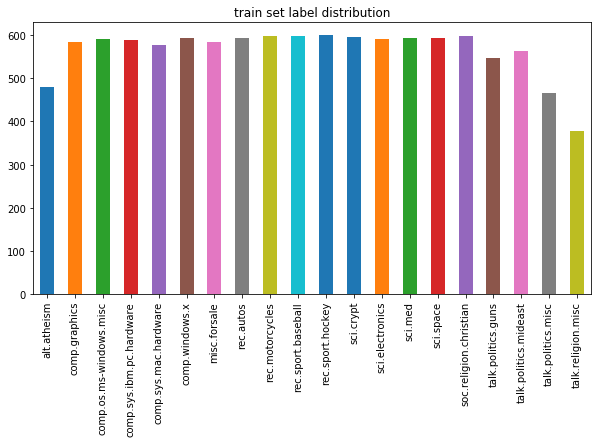

In [10]:
label_distributation(pd.DataFrame(data={'catid': y_train}), 'train set label distribution')

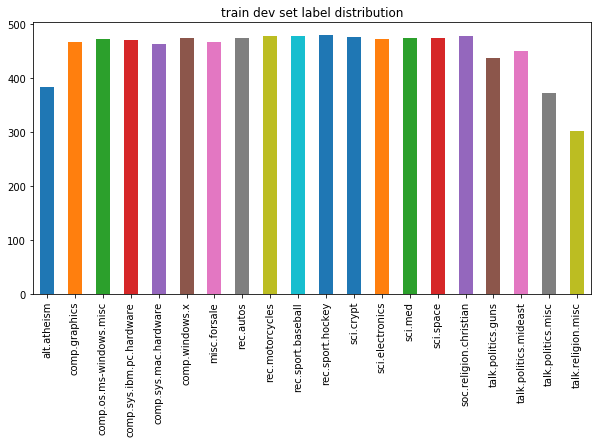

In [11]:
label_distributation(pd.DataFrame(data={'catid': y_train_dev}), 'train dev set label distribution')

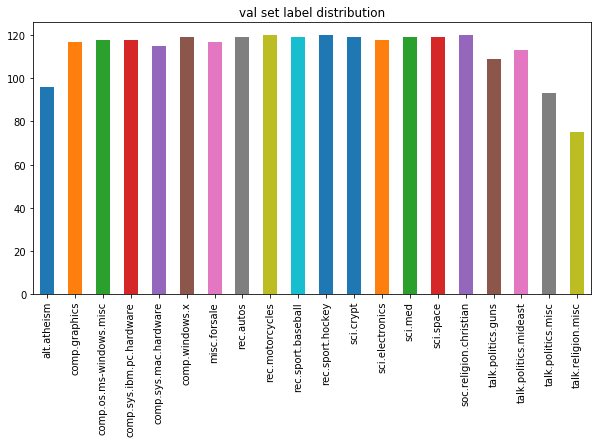

In [12]:
label_distributation(pd.DataFrame(data={'catid': y_val}), 'val set label distribution')

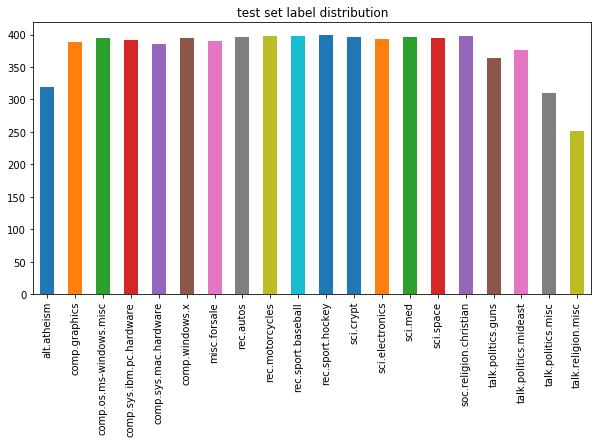

In [13]:
label_distributation(pd.DataFrame(data={'catid': y_test}), 'test set label distribution')

从上面几张图可以看到，训练集、验证集和测试集的数据在各个类别的分布比较均匀，只有一个类别`talk.religion.misc`数据量略小，预计不会对模型的指标有太大影响。

绘制训练集文档包含词数和字符数的直方图。

In [14]:
doc_word_count = []
doc_char_count = []
for i in X_train:
    doc_word_count.append(len(i.split()))
    doc_char_count.append(len(i))

def describe_data(data_name, data):
    print('{} min: {}'.format(data_name, np.min(data)))
    print('{} max: {}'.format(data_name, np.max(data)))
    print('{} 25 percent: {}'.format(data_name, np.percentile(data, 25)))
    print('{} 50 percent: {}'.format(data_name, np.percentile(data, 50)))
    print('{} 90 percent: {}'.format(data_name, np.percentile(data, 90)))
    print('{} 95 percent: {}'.format(data_name, np.percentile(data, 95)))
    plt.figure(figsize=(10,5))
    plt.hist(data, bins=50)
    plt.title('{} distribution'.format(data_name))
    plt.xlabel(data_name)
    plt.ylabel('doc num')
    plt.show()

artical word count min: 2
artical word count max: 11776
artical word count 25 percent: 72.0
artical word count 50 percent: 137.0
artical word count 90 percent: 461.7000000000007
artical word count 95 percent: 722.0


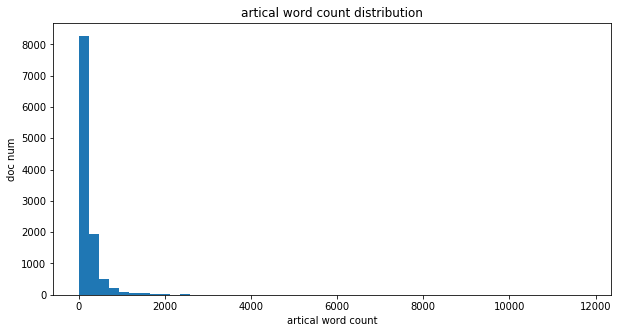

In [15]:
describe_data('artical word count', doc_word_count)

artical char count min: 12
artical char count max: 74932
artical char count 25 percent: 432.0
artical char count 50 percent: 818.5
artical char count 90 percent: 2765.4000000000015
artical char count 95 percent: 4349.050000000001


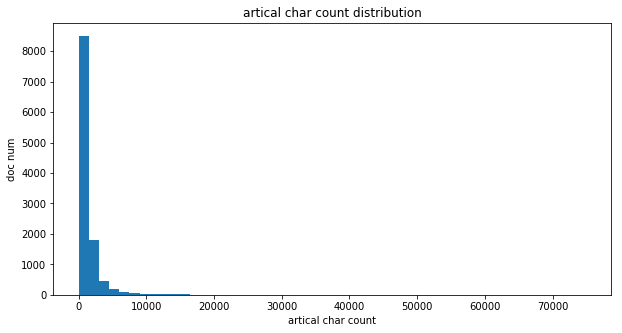

In [16]:
describe_data('artical char count', doc_char_count)

# 传统机器学习模型

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## BoW特征提取

In [18]:
count_vect = CountVectorizer(stop_words='english', min_df=3, max_df=0.95, max_features=None)
X_train_vec = count_vect.fit_transform(X_train)

In [19]:
print(X_train_vec.shape)
print(count_vect.transform([X_train[0]])[0])

(11314, 30787)
  (0, 1667)	1
  (0, 1868)	1
  (0, 2828)	1
  (0, 5207)	1
  (0, 5481)	1
  (0, 5674)	1
  (0, 5924)	1
  (0, 6058)	5
  (0, 8607)	1
  (0, 9860)	1
  (0, 9861)	1
  (0, 10204)	1
  (0, 10687)	1
  (0, 10715)	1
  (0, 12434)	1
  (0, 13936)	1
  (0, 14914)	1
  (0, 16304)	1
  (0, 16578)	1
  (0, 17171)	1
  (0, 17172)	1
  (0, 17472)	1
  (0, 18495)	1
  (0, 21924)	1
  (0, 22792)	1
  (0, 23509)	1
  (0, 24371)	1
  (0, 24788)	1
  (0, 25468)	1
  (0, 25840)	1
  (0, 25963)	1
  (0, 30103)	1
  (0, 30578)	1


In [20]:
print('id: 2705 feature name: {}'.format(count_vect.get_feature_names()[2705]))

print('id: 8155 feature name: {}'.format(count_vect.get_feature_names()[8155]))

id: 2705 feature name: accurate
id: 8155 feature name: critically


In [21]:
print('vocabulary size: {}'.format(len(count_vect.vocabulary_)))
print('stop word size: {}'.format(len(count_vect.stop_words_)))
print('sample vocabulary: {}'.format(list(count_vect.vocabulary_)[:100]))
print('sample stop words: {}'.format(list(count_vect.stop_words_)[:100]))

vocabulary size: 30787
stop word size: 65924
sample vocabulary: ['car', 'wondering', 'enlighten', 'saw', 'day', 'door', 'sports', 'looked', 'late', '60s', 'early', '70s', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'bumper', 'separate', 'rest', 'body', 'know', 'model', 'engine', 'specs', 'years', 'production', 'history', 'info', 'funky', 'looking', 'mail', 'si', 'clock', 'poll', 'final', 'fair', 'number', 'brave', 'souls', 'upgraded', 'oscillator', 'shared', 'experiences', 'send', 'brief', 'message', 'detailing', 'procedure', 'speed', 'attained', 'cpu', 'rated', 'add', 'cards', 'adapters', 'heat', 'sinks', 'hour', 'usage', 'floppy', 'disk', 'functionality', '800', 'floppies', 'especially', 'requested', 'summarizing', 'days', 'network', 'knowledge', 'base', 'upgrade', 'haven', 'answered', 'thanks', 'pb', 'questions', 'folks', 'mac', 'plus', 'finally', 'gave', 'ghost', 'weekend', 'starting', 'life', '512k', 'way', '1985', 'sooo', 'market', 'new', 'machine', 'bit', 'soon

## TFIDF特征

In [22]:
tfidf_transformer = TfidfTransformer()

# 基于整个训练集，提取TFIDF特征
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)

X_train_dev_tfidf = tfidf_transformer.transform(count_vect.transform(X_train_dev))
X_val_tfidf = tfidf_transformer.transform(count_vect.transform(X_val))
X_test_tfidf = tfidf_transformer.transform(count_vect.transform(X_test))

In [23]:
print(X_train_tfidf.shape)
print(X_train_tfidf[0])

(11314, 30787)
  (0, 6058)	0.560377102205
  (0, 30103)	0.129968356566
  (0, 10715)	0.19600020309
  (0, 24371)	0.123984407339
  (0, 8607)	0.0999988900377
  (0, 9860)	0.146546380695
  (0, 25963)	0.159245713964
  (0, 17171)	0.132006048773
  (0, 16578)	0.134783938018
  (0, 1667)	0.204688556255
  (0, 10204)	0.124787365695
  (0, 1868)	0.200627621892
  (0, 5924)	0.101539133043
  (0, 5481)	0.241668250879
  (0, 9861)	0.16936899488
  (0, 22792)	0.0835621915643
  (0, 25468)	0.110426414089
  (0, 2828)	0.139347678346
  (0, 5674)	0.194954791338
  (0, 24788)	0.146015371649
  (0, 23509)	0.119941465912
  (0, 5207)	0.127256906659
  (0, 16304)	0.0641420855486
  (0, 18495)	0.129193477405
  (0, 10687)	0.142098251346
  (0, 25840)	0.157867313996
  (0, 30578)	0.0895782496156
  (0, 21924)	0.159816870769
  (0, 13936)	0.122147261929
  (0, 14914)	0.111565274832
  (0, 12434)	0.228649092232
  (0, 17172)	0.101574352531
  (0, 17472)	0.0989855571819


## 初始模型评估

In [24]:
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    results = {}
    start = time()
    
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    results['train_time'] = end - start
    
    start = time()
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train)
    end = time()
    results['pred_time'] = end - start
    
    results['name'] = learner.__class__.__name__
    results['acc_train'] = accuracy_score(y_train, predictions_train)
    results['acc_val'] = accuracy_score(y_val, predictions_val)

    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))

    return results


In [25]:
def model_metrics(results, title, bar_width=0.2, group_width=0.6, metrics=(('train_time', 'pred_time'), ('acc_train', 'acc_val'))):
    fig, ax = plt.subplots(1, 2, figsize = (16,5))
    learner_count = len(results)
    
    for k, learner in enumerate(results.keys()):
        for i in range(2):
            ax[i].bar(k*group_width, results[learner][metrics[i][0]], width = bar_width, color='green', label=metrics[i][0])
            ax[i].text(k*group_width, results[learner][metrics[i][0]]+0.01, '%.2f' % (results[learner][metrics[i][0]]), ha='center', va= 'bottom')
            ax[i].bar(k*group_width+bar_width, results[learner][metrics[i][1]], width = bar_width, color='red', label=metrics[i][1])
            ax[i].text(k*group_width+bar_width, results[learner][metrics[i][1]]+0.01, '%.2f' % (results[learner][metrics[i][1]]), ha='center', va= 'bottom')

    ax[0].set_xticks(np.arange(bar_width/2, learner_count*group_width+bar_width/2, group_width))
    ax[0].set_xticklabels(results.keys())
    ax[0].set_xlabel("Model")
    ax[0].legend(loc='best')
    ax[0].set_xlim((-0.1, learner_count*group_width+bar_width))

    ax[1].set_xticks(np.arange(bar_width/2, learner_count*group_width+bar_width/2, group_width))
    ax[1].set_xticklabels(results.keys())
    ax[1].set_xlabel("Model")
    ax[1].legend(loc='best')
    ax[1].set_xlim((-0.1, learner_count*group_width+bar_width))
    
    # Add unique y-labels
    ax[0].set_ylabel("Time (in seconds)")
    ax[1].set_ylabel("Accuracy Score")
    
    # Add titles
    ax[0].set_title("Model Time")
    ax[1].set_title("Accuracy Score")
    
    # Set y-limits for score panels
    #ax[1].set_ylim((0, 1))

    plt.suptitle(title, fontsize = 16, y = 1.10)
    #plt.tight_layout()
    plt.show()

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

In [27]:
base_results = {}

In [28]:
tree = DecisionTreeClassifier(random_state=0)
base_results['DecisionTree'] = train_predict(tree, X_train_dev_tfidf.shape[0], X_train_dev_tfidf, y_train_dev, X_val_tfidf, y_val)
pprint(base_results['DecisionTree'])

DecisionTreeClassifier trained on 9051 samples.
{'acc_train': 0.99911611976577175,
 'acc_val': 0.65399911621741047,
 'name': 'DecisionTreeClassifier',
 'pred_time': 0.03128552436828613,
 'train_time': 8.76311707496643}


In [29]:
mnb = MultinomialNB()
base_results['NaiveBayes'] = train_predict(mnb, X_train_dev_tfidf.shape[0], X_train_dev_tfidf, y_train_dev, X_val_tfidf, y_val)
pprint(base_results['NaiveBayes'])

MultinomialNB trained on 9051 samples.
{'acc_train': 0.93989614407247823,
 'acc_val': 0.87096774193548387,
 'name': 'MultinomialNB',
 'pred_time': 0.0340421199798584,
 'train_time': 0.054418087005615234}


In [30]:
svm = LinearSVC(random_state=0)
base_results['SVM'] = train_predict(svm, X_train_dev_tfidf.shape[0], X_train_dev_tfidf, y_train_dev, X_val_tfidf, y_val)
pprint(base_results['SVM'])

LinearSVC trained on 9051 samples.
{'acc_train': 0.99779029941442932,
 'acc_val': 0.91471498011489172,
 'name': 'LinearSVC',
 'pred_time': 0.015629053115844727,
 'train_time': 0.9808297157287598}


In [31]:
pprint(base_results)

{'DecisionTree': {'acc_train': 0.99911611976577175,
                  'acc_val': 0.65399911621741047,
                  'name': 'DecisionTreeClassifier',
                  'pred_time': 0.03128552436828613,
                  'train_time': 8.76311707496643},
 'NaiveBayes': {'acc_train': 0.93989614407247823,
                'acc_val': 0.87096774193548387,
                'name': 'MultinomialNB',
                'pred_time': 0.0340421199798584,
                'train_time': 0.054418087005615234},
 'SVM': {'acc_train': 0.99779029941442932,
         'acc_val': 0.91471498011489172,
         'name': 'LinearSVC',
         'pred_time': 0.015629053115844727,
         'train_time': 0.9808297157287598}}


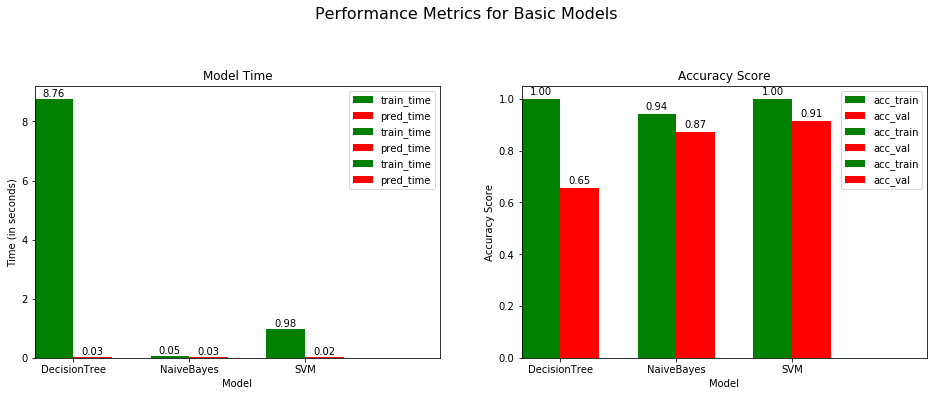

In [32]:
model_metrics(base_results, 'Performance Metrics for Basic Models')

## 模型调优

使用grid search寻找最优参数。

In [33]:
from sklearn.model_selection import GridSearchCV
def grid_search_cv(classifier, parameters, X_train, y_train):
    '''
    return metrics for the best model
    '''
    results = {}
    search = GridSearchCV(classifier(), parameters, cv=5, n_jobs=cpu_count()-1, return_train_score=True)

    search.fit(X_train, y_train)

    print('GridSearch for {}'.format(classifier.__name__))
    print('best params: {}'.format(search.best_params_))
    print('best score: {}'.format(search.best_score_))
    
    results['name'] = classifier.__name__
    results['search'] = search
    results['mean_train_time'] = np.mean(search.cv_results_['mean_fit_time'])
    results['mean_pred_time'] = np.mean(search.cv_results_['mean_score_time'])
    results['best_acc_train'] = search.cv_results_['mean_train_score'][search.best_index_]
    results['best_acc_val'] = search.cv_results_['mean_test_score'][search.best_index_]

    return results

In [34]:
improve_results = {}

In [35]:
parameters = {'max_depth': [10, 50, 100, 200, 500], 'min_samples_leaf': [2, 5, 10, 20, 50]}
improve_results['DecisionTree'] = grid_search_cv(DecisionTreeClassifier, parameters, X_train_tfidf, y_train)

GridSearch for DecisionTreeClassifier
best params: {'max_depth': 500, 'min_samples_leaf': 2}
best score: 0.6383242001060633


In [80]:
parameters = {'alpha': [.0001, .001, .01, .02, .03, .04, .05, .06, .1, .3, .5, .8]}
improve_results['NaiveBayes'] = grid_search_cv(MultinomialNB, parameters, X_train_tfidf, y_train)

GridSearch for MultinomialNB
best params: {'alpha': 0.02}
best score: 0.9044546579459077


In [37]:
parameters = {'C': [.1, .3, .5, .8, 1.0]}
improve_results['SVM'] = grid_search_cv(LinearSVC, parameters, X_train_tfidf, y_train)

GridSearch for LinearSVC
best params: {'C': 0.8}
best score: 0.9079017146897649


In [38]:
with open('improve_results.pkz', 'wb') as fp:
    pickle.dump(improve_results, fp)

In [39]:
if os.path.isfile('improve_results.pkz'):
    with open('improve_results.pkz', 'rb') as fp:
        improve_results = pickle.load(fp)

In [40]:
pprint(improve_results)

{'DecisionTree': {'best_acc_train': 0.91665219159237521,
                  'best_acc_val': 0.63832420010606328,
                  'mean_pred_time': 0.015100196838378906,
                  'mean_train_time': 5.6090377311706536,
                  'name': 'DecisionTreeClassifier',
                  'search': GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=7,
       param_grid={'max_depth': [10, 50, 100, 200, 500], 'min_samples_leaf': [2, 5, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)},
 'NaiveBayes': {'best_acc_train': 0.9868

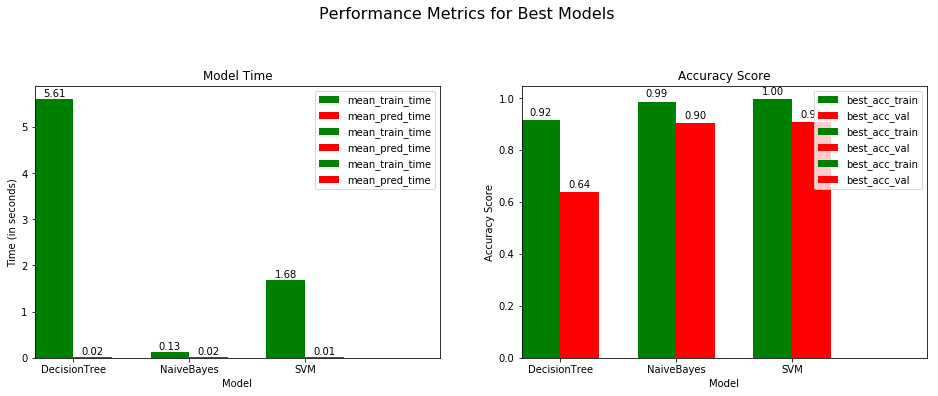

In [41]:
model_metrics(improve_results, 'Performance Metrics for Best Models',
              metrics=(('mean_train_time', 'mean_pred_time'), ('best_acc_train', 'best_acc_val')))

### 在测试集上的表现

In [58]:
model_names = ['DecisionTree', 'NaiveBayes', 'SVM']
for model_name in model_names:
    if model_name not in improve_results:
        continue
    print('{} test set acc: {}'.format(model_name, improve_results[model_name]['search'].best_estimator_.score(X_test_tfidf, y_test)))

DecisionTree test set acc: 0.563595326606479
NaiveBayes test set acc: 0.8127987254381307
SVM test set acc: 0.8193043016463091


### 基于最优模型的最优参数进一步调参

In [43]:
from sklearn.pipeline import make_pipeline

In [44]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer

punctuation_set = set(r',<.>/?;:\'"[{]}\|`~-_=+!@#$%^&*()')

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in punctuation_set]
    
class StemmerTokenizer(object):
    def __init__(self):
        self.stemmer = PorterStemmer()
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc) if t not in punctuation_set]


In [65]:
pipeline_unigram = make_pipeline(CountVectorizer(stop_words='english', min_df=3, max_df=0.95),
                        TfidfTransformer(),
                        MultinomialNB(**improve_results['NaiveBayes']['search'].best_params_))
print(train_predict(pipeline_unigram, len(X_train), X_train, y_train, X_test, y_test))

Pipeline trained on 11314 samples.
{'train_time': 2.298786163330078, 'pred_time': 3.1722347736358643, 'name': 'Pipeline', 'acc_train': 0.98479759589888638, 'acc_val': 0.8127987254381307}


In [67]:
pipeline_bigram = make_pipeline(CountVectorizer(stop_words='english', min_df=3, max_df=0.95, ngram_range=(1,2)),
                        TfidfTransformer(),
                        MultinomialNB(**improve_results['NaiveBayes']['search'].best_params_))
print(train_predict(pipeline_bigram, len(X_train), X_train, y_train, X_test, y_test))

Pipeline trained on 11314 samples.
{'train_time': 6.996674060821533, 'pred_time': 5.2832958698272705, 'name': 'Pipeline', 'acc_train': 0.99301750044193038, 'acc_val': 0.83072225172596925}


In [73]:
print(len(pipeline_bigram.named_steps['countvectorizer'].vocabulary_))

111189


In [79]:
pipeline_lemma = make_pipeline(CountVectorizer(stop_words='english', min_df=3, max_df=0.95, tokenizer=LemmaTokenizer()),
                        TfidfTransformer(),
                        MultinomialNB(**improve_results['NaiveBayes']['search'].best_params_))
print(train_predict(pipeline_lemma, len(X_train), X_train, y_train, X_test, y_test))

Pipeline trained on 11314 samples.
{'train_time': 36.97474026679993, 'pred_time': 60.172308921813965, 'name': 'Pipeline', 'acc_train': 0.98435566554710974, 'acc_val': 0.80881571959638876}


In [75]:
pipeline_stemmer = make_pipeline(CountVectorizer(stop_words='english', min_df=3, max_df=0.95, tokenizer=StemmerTokenizer()),
                        TfidfTransformer(),
                        MultinomialNB(**improve_results['NaiveBayes']['search'].best_params_)))
print(train_predict(pipeline_stemmer, len(X_train), X_train, y_train, X_test, y_test))

Pipeline trained on 11314 samples.
{'train_time': 71.00134778022766, 'pred_time': 116.90676379203796, 'name': 'Pipeline', 'acc_train': 0.9799363620293442, 'acc_val': 0.80855018587360594}


# 模型分析

In [48]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

show_top10(improve_results['NaiveBayes']['search'].best_estimator_, count_vect, newsgroups_target_names)

alt.atheism: islamic don writes islam edu morality people atheism atheists god
comp.graphics: cview need polygon looking thanks file files 3d image graphics
comp.os.ms-windows.misc: using win bmp card drivers driver files dos file windows
comp.sys.ibm.pc.hardware: dos isa disk pc controller bus ide card drive scsi
comp.sys.mac.hardware: lc duo scsi simms monitor centris quadra drive apple mac
comp.windows.x: use thanks windows application xterm x11r5 widget server motif window
misc.forsale: wanted sell price forsale condition new shipping offer 00 sale
rec.autos: new com like ford dealer just oil engine cars car
rec.motorcycles: dog com helmet bmw ride riding dod motorcycle bikes bike
rec.sport.baseball: pitching jewish braves runs games game team year players baseball
rec.sport.hockey: espn leafs games season players play nhl game team hockey
sci.crypt: security crypto nsa government escrow keys chip encryption key clipper
sci.electronics: electronics phone does need radar line know p

In [81]:
from sklearn import metrics

predicted = improve_results['NaiveBayes']['search'].best_estimator_.predict(X_test_tfidf)
print(metrics.classification_report(y_test, predicted, target_names=newsgroups_target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.73      0.69      0.71       319
           comp.graphics       0.72      0.80      0.76       389
 comp.os.ms-windows.misc       0.74      0.69      0.71       394
comp.sys.ibm.pc.hardware       0.66      0.77      0.71       392
   comp.sys.mac.hardware       0.81      0.81      0.81       385
          comp.windows.x       0.87      0.78      0.82       395
            misc.forsale       0.85      0.77      0.81       390
               rec.autos       0.86      0.88      0.87       396
         rec.motorcycles       0.90      0.88      0.89       398
      rec.sport.baseball       0.96      0.93      0.94       397
        rec.sport.hockey       0.93      0.97      0.95       399
               sci.crypt       0.87      0.93      0.90       396
         sci.electronics       0.80      0.71      0.75       393
                 sci.med       0.92      0.82      0.87       396
         

In [82]:
metrics.confusion_matrix(y_test, predicted)

array([[219,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   1,   0,
          4,   5,  48,   3,   8,   3,  26],
       [  1, 313,   8,  14,  11,  19,   1,   0,   0,   1,   0,  10,   2,
          1,   5,   1,   1,   1,   0,   0],
       [  0,  26, 270,  41,   6,  16,   5,   1,   0,   0,   1,   8,   2,
          1,   3,   2,   2,   0,   7,   3],
       [  0,   9,  31, 302,  25,   0,  11,   0,   0,   0,   0,   2,  12,
          0,   0,   0,   0,   0,   0,   0],
       [  1,   6,  11,  25, 312,   1,   7,   4,   0,   0,   0,   2,   8,
          0,   5,   1,   1,   0,   0,   1],
       [  0,  41,  21,  12,   1, 307,   2,   0,   0,   0,   3,   2,   2,
          0,   3,   0,   1,   0,   0,   0],
       [  0,   2,   2,  32,  16,   0, 299,  11,  10,   0,   2,   0,   8,
          0,   3,   1,   0,   1,   1,   2],
       [  0,   1,   1,   0,   0,   0,   6, 349,  15,   0,   1,   1,   8,
          0,   6,   1,   3,   0,   4,   0],
       [  0,   1,   0,   0,   1,   3,   4,  24, 349,   2,   0,  

In [52]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

In [86]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [84]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None, 
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(param_name)
    plt.ylabel("Score")

    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

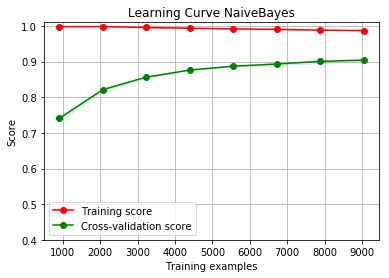

In [90]:
plot_learning_curve(improve_results['NaiveBayes']['search'].best_estimator_, 'Learning Curve NaiveBayes',
                    X_train_tfidf, y_train, (0.4, 1.01), cv=5, n_jobs=cpu_count()-1, train_sizes=np.linspace(.1, 1.0, 8))

plt.show()

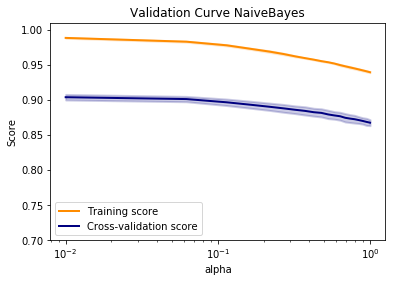

In [91]:
plot_validation_curve(improve_results['NaiveBayes']['search'].best_estimator_, 'Validation Curve NaiveBayes', 
                      X_train_tfidf, y_train, 
                      'alpha', np.linspace(.01, 1.0, 20),
                      (0.7, 1.01), cv=5, n_jobs=cpu_count()-1)

plt.show()

# 深度模型

## 词向量word2vec

In [92]:
import gensim
from gensim.models import word2vec

EMBEDDING_DIM = 100

D:\install\Anaconda3\envs\mlnd_capstone\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [93]:
if not os.path.isfile('word2vec/text8.model'):
    sentences = word2vec.Text8Corpus('word2vec/text8')
    wv_text8 = word2vec.Word2Vec(sentences, sg=0, size=EMBEDDING_DIM, workers=4)
    wv_text8.save('word2vec/text8.model')
    print('word2vec model trained and saved')
else:
    wv_text8 = word2vec.Word2Vec.load('word2vec/text8.model')
    print('word2vec model loaded from disk')

word2vec model trained and saved


In [94]:
def word2vec_accuracy(word_vector):
    word2vec_acc = word_vector.accuracy('word2vec/questions-words.txt')
    section_acc = {}
    total_correct = 0
    total_incorrect = 0
    for section in word2vec_acc:
        correct = len(section['correct'])
        incorrect = len(section['incorrect'])
        section_acc[section['section']] = float(correct) / (correct + incorrect)
        total_correct += correct
        total_incorrect += incorrect
    section_acc['total'] = float(total_correct) / (total_correct + total_incorrect)
    return section_acc

In [95]:
def word2vec_min_max(word_vector):
    cur_min = float('inf')
    cur_max = -float('inf')
    for key in word_vector.vocab:
        for value in word_vector[key]:
            if value > cur_max:
                cur_max = value
            if value < cur_min:
                cur_min = value
    return cur_min, cur_max

In [96]:
word2vec_min_max(wv_text8.wv)

(-10.036307, 8.7793503)

In [97]:
print(word2vec_accuracy(wv_text8.wv))

{'capital-common-countries': 0.3221343873517787, 'capital-world': 0.1590909090909091, 'currency': 0.11567164179104478, 'city-in-state': 0.0967536600891152, 'family': 0.7516339869281046, 'gram1-adjective-to-adverb': 0.11772486772486772, 'gram2-opposite': 0.16666666666666666, 'gram3-comparative': 0.5484126984126985, 'gram4-superlative': 0.34782608695652173, 'gram5-present-participle': 0.29838709677419356, 'gram6-nationality-adjective': 0.5061998541210795, 'gram7-past-tense': 0.24924924924924924, 'gram8-plural': 0.3790322580645161, 'gram9-plural-verbs': 0.34615384615384615, 'total': 0.3046136289533746}


In [98]:
print(wv_text8.wv.evaluate_word_pairs('word2vec/wordsim353.tsv'))

((0.60916544339846934, 4.988857452756329e-37), SpearmanrResult(correlation=0.62176543678605323, pvalue=6.2645893427999052e-39), 0.56657223796034)


## 词向量Glovec 预训练

In [99]:
from gensim.scripts.glove2word2vec import glove2word2vec

if not os.path.isfile('word2vec/glove2word2vec.6B.100d.txt'):
    glove2word2vec('word2vec/glove.6B.100d.txt', 'word2vec/glove2word2vec.6B.100d.txt')

wv_glove = gensim.models.KeyedVectors.load_word2vec_format('word2vec/glove2word2vec.6B.100d.txt',binary=False)

In [100]:
word2vec_min_max(wv_glove.wv)

(-4.0665998, 3.575)

In [101]:
print(word2vec_accuracy(wv_glove.wv))

{'capital-common-countries': 0.9426877470355731, 'capital-world': 0.8939226519337017, 'currency': 0.17796610169491525, 'city-in-state': 0.31230140717203814, 'family': 0.8771929824561403, 'gram1-adjective-to-adverb': 0.2206896551724138, 'gram2-opposite': 0.23421052631578948, 'gram3-comparative': 0.7935435435435435, 'gram4-superlative': 0.5983333333333334, 'gram5-present-participle': 0.6946236559139785, 'gram6-nationality-adjective': 0.9487889273356401, 'gram7-past-tense': 0.5544871794871795, 'gram8-plural': 0.7793560606060606, 'gram9-plural-verbs': 0.5797720797720798, 'total': 0.6549035423808564}


In [102]:
print(wv_glove.wv.evaluate_word_pairs('word2vec/wordsim353.tsv'))

((0.5483502271903985, 4.2350974945224685e-29), SpearmanrResult(correlation=0.53273543232382736, pvalue=2.8654146580558905e-27), 0.0)


In [103]:
def load_glove():
    embeddings_index = {}
    f = open('word2vec/glove.6B.100d.txt', encoding='utf8')

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index


# 深度模型

In [104]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Flatten, Merge
from keras.layers import Conv1D, Convolution1D, Activation, MaxPooling1D, MaxPool1D, GRU, Embedding, LSTM
from keras.models import Model, Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping

MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

Using TensorFlow backend.


In [105]:
class FixLengthTokenizer():
    '''
    tokenize doc and padding to fix length
    '''
    def __init__(self, num_words, maxlen):
        self.tokenizer = Tokenizer(num_words=num_words)
        self.word_index = {}
        self.is_fitted = False
        self.maxlen = maxlen
    
    def fit(self, raw_documents):
        self.tokenizer.fit_on_texts(raw_documents)
        self.word_index = self.tokenizer.word_index
        self.is_fitted = True
    
    def transform(self, raw_documents):
        if not self.is_fitted:
            raise Exception('tokenizer not fitted yet')
        return pad_sequences(self.tokenizer.texts_to_sequences(raw_documents), maxlen=self.maxlen)

In [145]:
print('Processing text dataset')

vectorizer = FixLengthTokenizer(MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH)
vectorizer.fit(X_train)

print('Found %s unique tokens.' % len(vectorizer.word_index))

X_train_dl = vectorizer.transform(X_train_dev)
y_train_dl = to_categorical(np.asarray(y_train_dev), num_classes=20)

X_val_dl = vectorizer.transform(X_val)
y_val_dl = to_categorical(np.asarray(y_val), num_classes=20)

X_test_dl = vectorizer.transform(X_test)
y_test_dl = to_categorical(np.asarray(y_test), num_classes=20)

print('Shape of train data tensor:', X_train_dl.shape)
print('Shape of train label tensor:', y_train_dl.shape)

Processing text dataset
Found 100212 unique tokens.
Shape of train data tensor: (9051, 1000)
Shape of train label tensor: (9051, 20)


In [107]:
def build_embedding_matrix(word_vector, word_index, num_words, embedding_dim, random_initialize=False):
    # no word idx 0, embedding size num_words+1
    embedding_matrix = np.zeros((num_words+1, embedding_dim))

    for word, i in word_index.items():
        if i > num_words:
            continue
        if word in word_vector:
            embedding_matrix[i] = word_vector[word]
        else:
            if random_initialize:
                embedding_matrix[i] = np.random.uniform(-5, 5, embedding_dim)
    
    return embedding_matrix

In [108]:
# Preparing embedding matrix

num_words = min(MAX_NUM_WORDS, len(vectorizer.word_index))

embedding_matrix = build_embedding_matrix(wv_glove.wv, vectorizer.word_index, num_words, EMBEDDING_DIM, True)

print('embedding matrix shape: {}'.format(embedding_matrix.shape))

embedding matrix shape: (20001, 100)


In [124]:
def plot_keras_history(history):
    fig, ax = plt.subplots(1, 2, figsize = (16,5))
    ax[0].plot(range(1, len(history['acc']) + 1), history['acc'], label='train')
    ax[0].plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label='val')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(loc='best')
    ax[0].set_title('Train acc')
    ax[0].set_xticks(range(1, len(history['acc']) + 1, 5))
    ax[0].set_ylim((0, 1))

    ax[1].plot(range(1, len(history['loss']) + 1), history['loss'], label='train')
    ax[1].plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label='val')
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend(loc='best')
    ax[1].set_title('Train loss')
    ax[1].set_xticks(range(1, len(history['acc']) + 1, 5))
    
    fig.show()

## TextCNN

In [110]:
def TextCNN(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    if embeddings is None:
        embedding_layer = Embedding(num_words+1,
                                embedding_dim,
                                input_length=max_sequence_length,
                                trainable=True)
    else:
        embedding_layer = Embedding(num_words+1,
                                embedding_dim,
                                weights=[embeddings],
                                input_length=max_sequence_length,
                                trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #optional dropout
    x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [111]:
text_cnn = TextCNN(embedding_matrix, MAX_SEQUENCE_LENGTH, num_words, EMBEDDING_DIM, len(newsgroups_target_names), False)

D:\install\Anaconda3\envs\mlnd_capstone\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [112]:
text_cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    2000100     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 998, 128)     38528       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 997, 128)     51328       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [113]:
%%time
history = text_cnn.fit(X_train_dl, y_train_dl, validation_data=(X_val_dl, y_val_dl), epochs=60, batch_size=128)

Train on 9051 samples, validate on 2263 samples
Epoch 1/60
9051/9051 [==============================] - 11s 1ms/step - loss: 3.2267 - acc: 0.0582 - val_loss: 2.9857 - val_acc: 0.0663
Epoch 2/60
9051/9051 [==============================] - 9s 985us/step - loss: 2.9491 - acc: 0.0816 - val_loss: 2.9402 - val_acc: 0.0831
Epoch 3/60
9051/9051 [==============================] - 9s 991us/step - loss: 2.8308 - acc: 0.1168 - val_loss: 2.7561 - val_acc: 0.1467
Epoch 4/60
9051/9051 [==============================] - 9s 996us/step - loss: 2.5778 - acc: 0.1851 - val_loss: 2.3440 - val_acc: 0.2262
Epoch 5/60
9051/9051 [==============================] - 9s 993us/step - loss: 2.1599 - acc: 0.2782 - val_loss: 2.0001 - val_acc: 0.3403
Epoch 6/60
9051/9051 [==============================] - 9s 995us/step - loss: 1.8690 - acc: 0.3655 - val_loss: 1.8305 - val_acc: 0.3990
Epoch 7/60
9051/9051 [==============================] - 9s 993us/step - loss: 1.6268 - acc: 0.4382 - val_loss: 1.7072 - val_acc: 0.4278
E

Wall time: 9min 6s


D:\install\Anaconda3\envs\mlnd_capstone\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


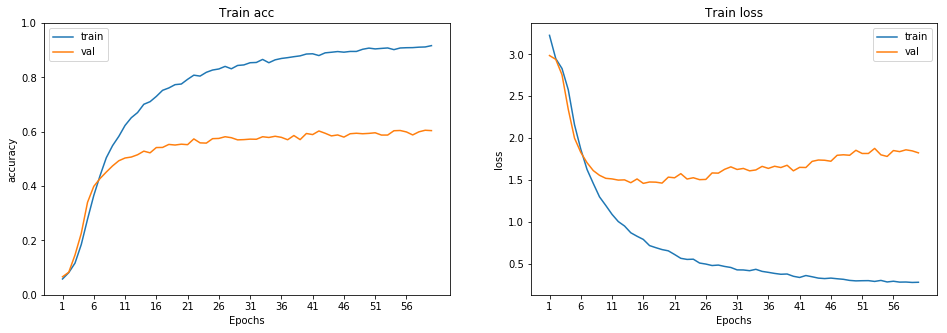

In [125]:
plot_keras_history(history.history)

In [115]:
score = text_cnn.evaluate(X_test_dl, y_test_dl, batch_size=128)

7532/7532 [==============================] - 2s 256us/step


In [116]:
print(text_cnn.metrics_names)
print(score)

['loss', 'acc']
[2.0315647367081362, 0.56771109946788278]


## Text8 word2vec text CNN

In [127]:
text_cnn_text8 = TextCNN(build_embedding_matrix(wv_text8.wv, vectorizer.word_index, num_words, EMBEDDING_DIM, True),
                         MAX_SEQUENCE_LENGTH, num_words, EMBEDDING_DIM, len(newsgroups_target_names), False)
history = text_cnn_text8.fit(X_train_dl, y_train_dl, validation_data=(X_val_dl, y_val_dl), epochs=40, batch_size=128)
print(text_cnn_text8.evaluate(X_test_dl, y_test_dl, batch_size=128))

D:\install\Anaconda3\envs\mlnd_capstone\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 9s 1ms/step - loss: 3.9412 - acc: 0.0517 - val_loss: 2.9960 - val_acc: 0.0561
Epoch 2/40
9051/9051 [==============================] - 9s 979us/step - loss: 3.0018 - acc: 0.0506 - val_loss: 2.9911 - val_acc: 0.0544
Epoch 3/40
9051/9051 [==============================] - 9s 983us/step - loss: 2.9866 - acc: 0.0547 - val_loss: 2.9767 - val_acc: 0.0601
Epoch 4/40
9051/9051 [==============================] - 9s 985us/step - loss: 2.9791 - acc: 0.0570 - val_loss: 2.9671 - val_acc: 0.0734
Epoch 5/40
9051/9051 [==============================] - 9s 984us/step - loss: 2.9608 - acc: 0.0689 - val_loss: 2.9592 - val_acc: 0.0751
Epoch 6/40
9051/9051 [==============================] - 9s 984us/step - loss: 2.9360 - acc: 0.0719 - val_loss: 2.9580 - val_acc: 0.0738
Epoch 7/40
9051/9051 [==============================] - 9s 987us/step - loss: 2.9291 - acc: 0.0715 - val_loss: 2.8296 - val_acc: 0.0999
Ep

In [146]:
history = text_cnn_text8.fit(X_train_dl, y_train_dl, validation_data=(X_val_dl, y_val_dl), epochs=100, batch_size=128)
print(text_cnn_text8.evaluate(X_test_dl, y_test_dl, batch_size=128))

Train on 9051 samples, validate on 2263 samples
Epoch 1/100
9051/9051 [==============================] - 9s 988us/step - loss: 2.2598 - acc: 0.2175 - val_loss: 2.3577 - val_acc: 0.2236
Epoch 2/100
9051/9051 [==============================] - 9s 987us/step - loss: 2.2427 - acc: 0.2153 - val_loss: 2.3493 - val_acc: 0.2099
Epoch 3/100
9051/9051 [==============================] - 9s 990us/step - loss: 2.2333 - acc: 0.2170 - val_loss: 2.3522 - val_acc: 0.2037
Epoch 4/100
9051/9051 [==============================] - 9s 991us/step - loss: 2.2217 - acc: 0.2228 - val_loss: 2.3427 - val_acc: 0.2143
Epoch 5/100
9051/9051 [==============================] - 9s 992us/step - loss: 2.2063 - acc: 0.2245 - val_loss: 2.3435 - val_acc: 0.2258
Epoch 6/100
9051/9051 [==============================] - 9s 992us/step - loss: 2.1936 - acc: 0.2230 - val_loss: 2.3244 - val_acc: 0.2209
Epoch 7/100
9051/9051 [==============================] - 9s 992us/step - loss: 2.1875 - acc: 0.2333 - val_loss: 2.3324 - val_acc: 

9051/9051 [==============================] - 9s 1000us/step - loss: 1.7709 - acc: 0.3607 - val_loss: 2.3087 - val_acc: 0.2824
Epoch 61/100
9051/9051 [==============================] - 9s 998us/step - loss: 1.7600 - acc: 0.3676 - val_loss: 2.3119 - val_acc: 0.2863
Epoch 62/100
9051/9051 [==============================] - 9s 998us/step - loss: 1.7781 - acc: 0.3597 - val_loss: 2.2718 - val_acc: 0.2806
Epoch 63/100
9051/9051 [==============================] - 9s 998us/step - loss: 1.7489 - acc: 0.3646 - val_loss: 2.3417 - val_acc: 0.2983
Epoch 64/100
9051/9051 [==============================] - 9s 999us/step - loss: 1.7367 - acc: 0.3682 - val_loss: 2.2967 - val_acc: 0.2824
Epoch 65/100
9051/9051 [==============================] - 9s 998us/step - loss: 1.7543 - acc: 0.3682 - val_loss: 2.2825 - val_acc: 0.3142
Epoch 66/100
9051/9051 [==============================] - 9s 1000us/step - loss: 1.7413 - acc: 0.3664 - val_loss: 2.3480 - val_acc: 0.2987
Epoch 67/100
9051/9051 [=====================

D:\install\Anaconda3\envs\mlnd_capstone\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


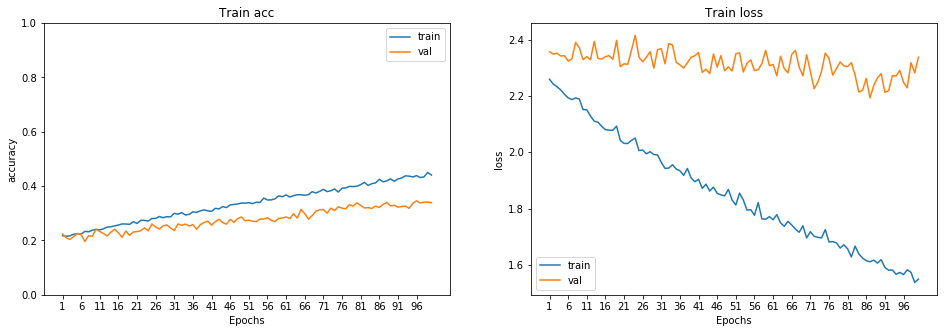

In [147]:
plot_keras_history(history.history)

## C-LSTM

In [129]:
 def Lstm(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    model = Sequential()
    model.add(Embedding(num_words+1,
                        embedding_dim,
                        input_length=max_sequence_length,
                        trainable=True))
    model.add(Convolution1D(256, 3, padding='same', strides = 1))
    model.add(Activation('relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(GRU(256, dropout=0.2, recurrent_dropout=0.1, return_sequences = True))
    model.add(GRU(256, dropout=0.2, recurrent_dropout=0.1))
    model.add(Dense(labels_index, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [130]:
lstm = Lstm(embedding_matrix, MAX_SEQUENCE_LENGTH, num_words, EMBEDDING_DIM, len(newsgroups_target_names))

In [131]:
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         2000100   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1000, 256)         77056     
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 256)         0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 500, 256)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 500, 256)          393984    
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_5 (Dense)              (None, 20)                5140      
Total para

In [132]:
%%time
history = lstm.fit(X_train_dl, y_train_dl, validation_data=(X_val_dl, y_val_dl), epochs=30, batch_size=128)

Train on 9051 samples, validate on 2263 samples
Epoch 1/30
9051/9051 [==============================] - 100s 11ms/step - loss: 2.8880 - acc: 0.0835 - val_loss: 2.5543 - val_acc: 0.1374
Epoch 2/30
9051/9051 [==============================] - 98s 11ms/step - loss: 2.0624 - acc: 0.2741 - val_loss: 1.6438 - val_acc: 0.4123
Epoch 3/30
9051/9051 [==============================] - 98s 11ms/step - loss: 1.1397 - acc: 0.5799 - val_loss: 1.0592 - val_acc: 0.6469
Epoch 4/30
9051/9051 [==============================] - 98s 11ms/step - loss: 0.5172 - acc: 0.8314 - val_loss: 0.8343 - val_acc: 0.7609
Epoch 5/30
9051/9051 [==============================] - 98s 11ms/step - loss: 0.2549 - acc: 0.9184 - val_loss: 0.8611 - val_acc: 0.7689
Epoch 6/30
9051/9051 [==============================] - 98s 11ms/step - loss: 0.1378 - acc: 0.9600 - val_loss: 0.8347 - val_acc: 0.8078
Epoch 7/30
9051/9051 [==============================] - 101s 11ms/step - loss: 0.0898 - acc: 0.9751 - val_loss: 0.8842 - val_acc: 0.802

KeyboardInterrupt: 

D:\install\Anaconda3\envs\mlnd_capstone\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


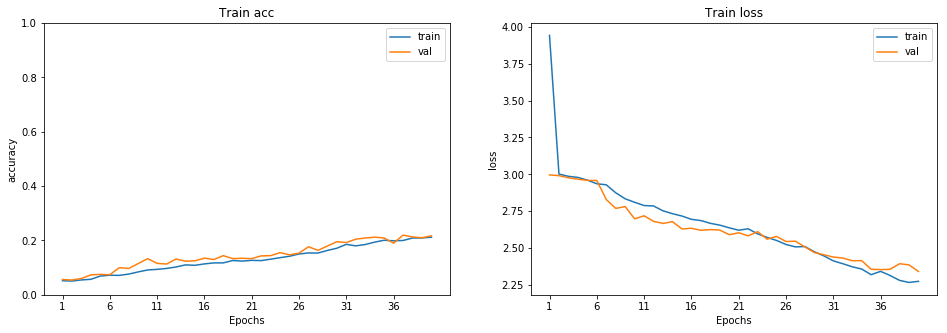

In [133]:
plot_keras_history(history.history)

In [134]:
score = lstm.evaluate(X_test_dl, y_test_dl, batch_size=128)

7532/7532 [==============================] - 17s 2ms/step


In [135]:
print(lstm.metrics_names)
print(score)

['loss', 'acc']
[1.5945341758631799, 0.69702602262137359]


## char cnn

In [136]:
class CharVectorizer:
    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}\n"

    def __init__(self, max_seq_length):
        self.char_map = {}
        self.max_seq_length = max_seq_length
        for i, c in enumerate(self.alphabet):
            if c in self.char_map:
                print('duplicated char: {}'.format(c))
            self.char_map[c] = i

    def transform(self, raw_documents):
        transformed_documents = np.zeros((len(raw_documents), self.max_seq_length, len(self.char_map)), dtype='bool')
        for i, document in enumerate(raw_documents):
            document = document.lower()[:self.max_seq_length]
            onehot = np.zeros((self.max_seq_length, len(self.char_map)), dtype='bool')
            for j, c in enumerate(reversed(document)):
                if c in self.char_map:
                    onehot[j][self.char_map[c]] = 1
            transformed_documents[i] = onehot

        return transformed_documents

In [137]:
MAX_CHAR_SEQUENCE_LENGTH = 3500
char_vectorizer = CharVectorizer(MAX_CHAR_SEQUENCE_LENGTH)

X_train_dl_ch = char_vectorizer.transform(X_train_dev)
y_train_dl_ch = to_categorical(np.asarray(y_train_dev), num_classes=20)

X_val_dl_ch = char_vectorizer.transform(X_val)
y_val_dl_ch = to_categorical(np.asarray(y_val), num_classes=20)

X_test_dl_ch = char_vectorizer.transform(X_val)
y_test_dl_ch = to_categorical(np.asarray(y_val), num_classes=20)

In [138]:
print('X_train shape:{}'.format(X_train_dl_ch.shape))

X_train shape:(9051, 3500, 69)


In [139]:
def char_cnn(n_vocab, max_len, n_classes):

    "See Zhang and LeCun, 2015"

    model = Sequential()

    model.add(Conv1D(256, 7, activation='relu', input_shape=(max_len, n_vocab)))
    model.add(MaxPooling1D(3))

    model.add(Conv1D(256, 7, activation='relu'))
    model.add(MaxPooling1D(3))

    model.add(Conv1D(256, 3, activation='relu'))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(MaxPooling1D(3))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [141]:
char_model = char_cnn(len(CharVectorizer.alphabet), MAX_CHAR_SEQUENCE_LENGTH, len(newsgroups_target_names))

In [142]:
char_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 3494, 256)         123904    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 1164, 256)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1158, 256)         459008    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 386, 256)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 384, 256)          196864    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 382, 256)          196864    
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 380, 256)          196864    
__________

In [143]:
%%time
history = char_model.fit(X_train_dl_ch, y_train_dl_ch, validation_data=(X_val_dl_ch, y_val_dl_ch), epochs=40, batch_size=128)

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 53s 6ms/step - loss: 2.9658 - acc: 0.0635 - val_loss: 2.9773 - val_acc: 0.0566
Epoch 2/40
1664/9051 [====>.........................] - ETA: 36s - loss: 2.9605 - acc: 0.0709

KeyboardInterrupt: 

In [ ]:
plot_keras_history(history.history)

In [ ]:
score = char_model.evaluate(X_test_dl_ch, y_test_dl_ch, batch_size=128)

In [ ]:
print(char_model.metrics_names)
print(score)